In [1]:
from salishsea_tools import viz_tools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import xarray as xr
import cmocean.cm as cm
import glob
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import pandas as pd
import salishsea_tools.river_202108 as rivers

In [2]:
fw = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_allR_00_40_20120101_20121231.nc')
phys = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_allP_00_40_20120101_20121231.nc')

In [3]:
# dimensions: gridY, gridX, time
sum_2023 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2023, 2023))
sum_2022 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2022, 2022))
sum_2021 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2021, 2021))
sum_2020 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2020, 2020))
sum_2019 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_{}0101_{}1231_e3t_3d_vol_e3t_depsum_vol.nc'.format(2019, 2019))

In [4]:
# dimensions: gridY, gridX, time
vol_2023_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol.nc'.format(2023, 2023))
vol_2022_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol.nc'.format(2022, 2022))
vol_2021_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol.nc'.format(2021, 2021))
vol_2020_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol.nc'.format(2020, 2020))
vol_2019_mon = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_res1M_{}0101_{}1231_e3t_3d_vol.nc'.format(2019, 2019))

In [5]:
vol_2022 = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/transformations/3d_hindcast_vol/SalishSeaCast_river_trace_day_avg_allR_00_40_{}0101_{}1231_e3t_3d_vol.nc'.format(2022, 2022))

In [6]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

volume = (1-tmask) * mesh.e3t_0[0] * mesh.e1t[0] * mesh.e2t[0]
volume_dims = np.array([volume.to_numpy(), volume.to_numpy()])[0:1] ## do this once, pass volume dims into it

volume = ((1-tmask) * mesh.e3t_0[0] * mesh.e1t[0] * mesh.e2t[0]).rename({'z':'depth', 'y':'gridY', 'x':'gridX'})
rho_inv = (1/1026)
fudge = 0.00001

## Check Sum Plots

Text(25.09722222222222, 0.5, 'Grid Y')

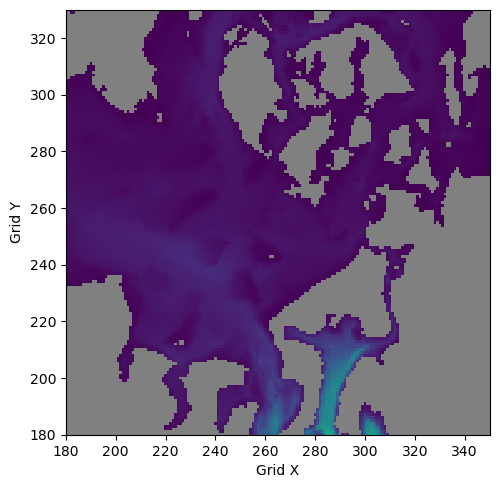

In [7]:
field_time_sel = sum_2019.isel(time=180)

fig, ax = plt.subplots(1, 1, figsize=(5, 9))
fig.tight_layout(pad=1.2)

mycmap = mpl.colormaps['viridis']
mycmap.set_bad('grey')

X = field_time_sel.gridX
Y = field_time_sel.gridY
Z = np.ma.masked_array(field_time_sel['snohomish_river'], mask=tmask[0])

ax.pcolormesh(X, Y, Z, cmap=mycmap)
ax.set_title('')
ax.set_xlim(180,350)
ax.set_ylim(180,330)
viz_tools.set_aspect(ax);
ax.set_xlabel('Grid X')
ax.set_ylabel('Grid Y')

## Animate Rivers

In [8]:
## define a "global" fps for all the animations
writervideo = animation.FFMpegWriter(fps=10)

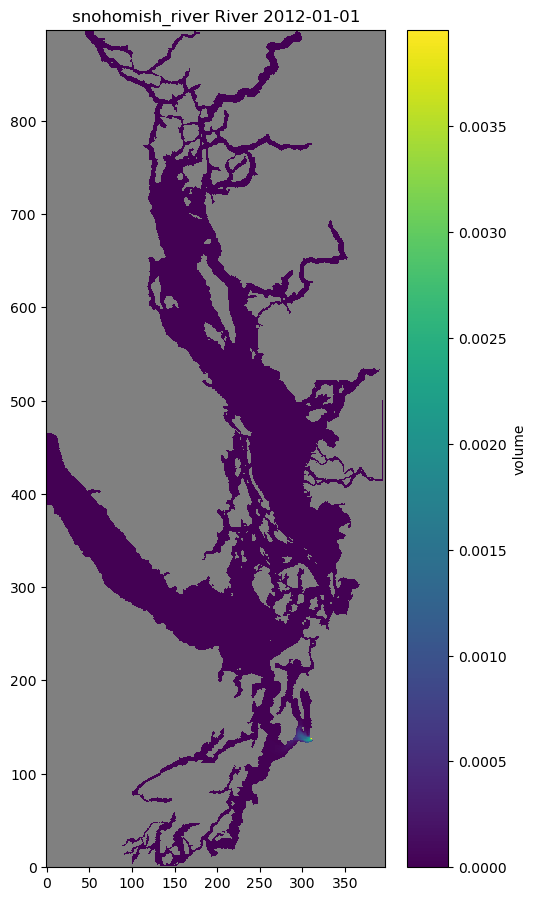

In [9]:
river = 'snohomish_river'
fname = '{}_daily_animation'.format(river)
writervideo = animation.FFMpegWriter(fps=10)
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 1, figsize=(5, 9))
fig.tight_layout(pad=1.2)

depth = 0
river_concentration = fw[river].isel(depth=depth) / volume.isel(depth=depth)
X = fw.gridX
Y = fw.gridY
Z = np.ma.masked_array(river_concentration.isel(time=0), mask=tmask[depth])
colours = ax.pcolormesh(X, Y, Z, cmap=cmap)
cb = fig.colorbar(colours, ax=ax, label='volume')

def newframe(frame_num):
    freshwater = np.ma.masked_array(river_concentration.isel(time=frame_num), mask=tmask[depth])
    Z = freshwater
    colours.set_array(Z.ravel())
    dtime = pd.to_datetime(fw['time'].values[frame_num])
    ax.set_title('{} River {}'.format(river, str(dtime.date())))

ani = FuncAnimation(fig, newframe, frames=len(fw['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/stories/puget_sound/{}.mp4'.format(fname), writer=writervideo)

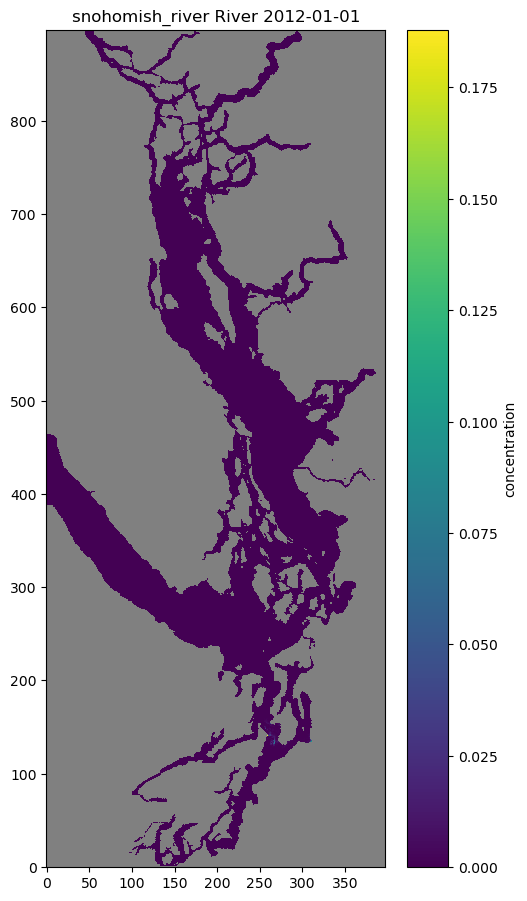

In [10]:
river = 'snohomish_river'
fname = '{}_daily_animation_d10'.format(river)
writervideo = animation.FFMpegWriter(fps=10)
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 1, figsize=(5, 9))
fig.tight_layout(pad=1.2)

depth = 10
river_concentration = fw[river].isel(depth=depth)
X = fw.gridX
Y = fw.gridY
Z = np.ma.masked_array(river_concentration.isel(time=0), mask=tmask[depth])
colours = ax.pcolormesh(X, Y, Z, cmap=cmap)
cb = fig.colorbar(colours, ax=ax, label='concentration')
# ax.set_xlim(180,350)
# ax.set_ylim(180,330)

def newframe(frame_num):
    freshwater = np.ma.masked_array(river_concentration.isel(time=frame_num), mask=tmask[depth])
    Z = freshwater
    colours.set_array(Z.ravel())
    dtime = pd.to_datetime(fw['time'].values[frame_num])
    ax.set_title('{} River {}'.format(river, str(dtime.date())))
    # ax.set_xlim(180,350)
    # ax.set_ylim(180,330)

ani = FuncAnimation(fig, newframe, frames=len(fw['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/stories/puget_sound/{}.mp4'.format(fname), writer=writervideo)

## Sum Animation

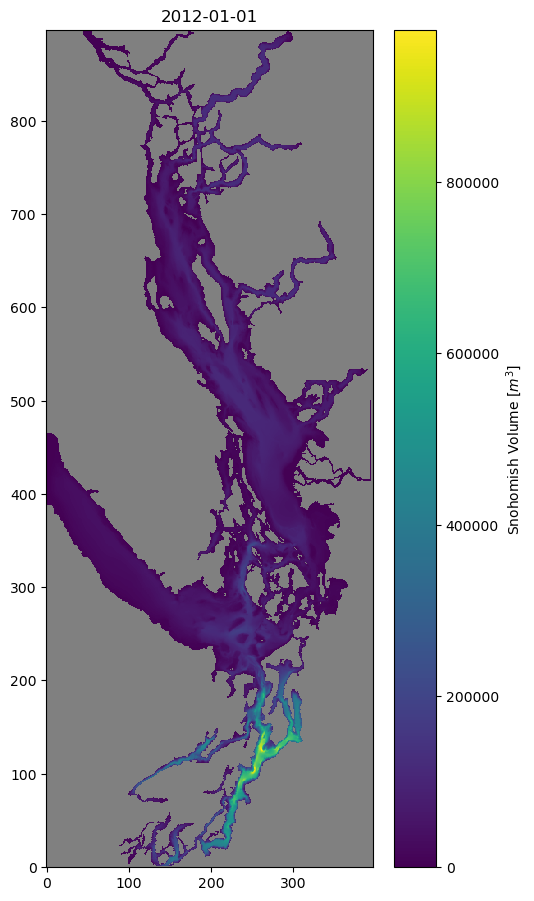

In [11]:
river = 'snohomish_river'
fname = '{}_daily_animation_sum_2019'.format(river)
writervideo = animation.FFMpegWriter(fps=10)
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 1, figsize=(5, 9))
fig.tight_layout(pad=1.2)

depth = 0
river_sum = sum_2019['snohomish_river']
X = fw.gridX
Y = fw.gridY
Z = np.ma.masked_array(river_sum.isel(time=0), mask=tmask[depth])
colours = ax.pcolormesh(X, Y, Z, cmap=cmap)
cb = fig.colorbar(colours, ax=ax, label=r'Snohomish Volume [$m^3$]')
viz_tools.set_aspect(ax);
# ax.set_xlim(180,350)
# ax.set_ylim(180,330)

def newframe(frame_num):
    freshwater = np.ma.masked_array(river_sum.isel(time=frame_num), mask=tmask[depth])
    Z = freshwater
    colours.set_array(Z.ravel())
    dtime = pd.to_datetime(fw['time'].values[frame_num])
    ax.set_title('{}'.format(str(dtime.date())))
    viz_tools.set_aspect(ax);
    # ax.set_xlim(180,350)
    # ax.set_ylim(180,330)

ani = FuncAnimation(fig, newframe, frames=len(sum_2019['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/stories/puget_sound/{}.mp4'.format(fname), writer=writervideo)

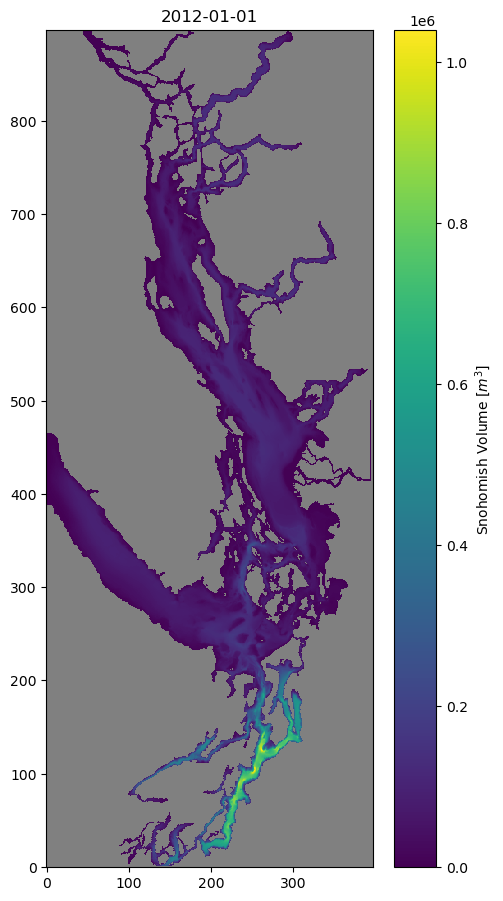

In [12]:
river = 'snohomish_river'
fname = '{}_daily_animation_sum_2022'.format(river)
writervideo = animation.FFMpegWriter(fps=10)
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 1, figsize=(5, 9))
fig.tight_layout(pad=1.2)

depth = 0
river_sum = sum_2022['snohomish_river']
X = fw.gridX
Y = fw.gridY
Z = np.ma.masked_array(river_sum.isel(time=0), mask=tmask[depth])
colours = ax.pcolormesh(X, Y, Z, cmap=cmap)
cb = fig.colorbar(colours, ax=ax, label=r'Snohomish Volume [$m^3$]')
viz_tools.set_aspect(ax);
# ax.set_xlim(180,350)
# ax.set_ylim(180,330)

def newframe(frame_num):
    freshwater = np.ma.masked_array(river_sum.isel(time=frame_num), mask=tmask[depth])
    Z = freshwater
    colours.set_array(Z.ravel())
    dtime = pd.to_datetime(fw['time'].values[frame_num])
    ax.set_title('{}'.format(str(dtime.date())))
    viz_tools.set_aspect(ax);
    # ax.set_xlim(180,350)
    # ax.set_ylim(180,330)

ani = FuncAnimation(fig, newframe, frames=len(sum_2022['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/stories/puget_sound/{}.mp4'.format(fname), writer=writervideo)

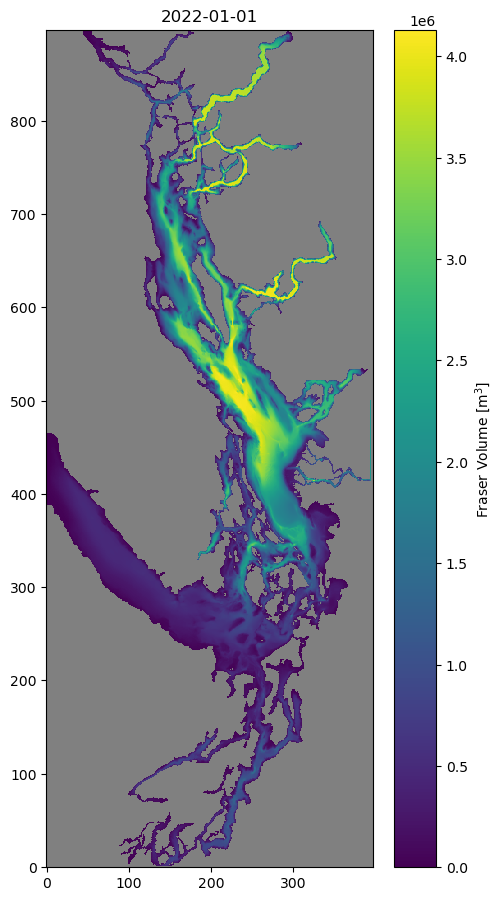

In [16]:
river = 'fraser_river'
fname = '{}_daily_animation_sum_2022'.format(river)
writervideo = animation.FFMpegWriter(fps=10)
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 1, figsize=(5, 9))
fig.tight_layout(pad=1.2)

depth = 0
river_sum = sum_2022['fraser_river']
X = sum_2022.gridX
Y = sum_2022.gridY
Z = np.ma.masked_array(river_sum.isel(time=0), mask=tmask[depth])
colours = ax.pcolormesh(X, Y, Z, cmap=cmap)
cb = fig.colorbar(colours, ax=ax, label=r'Fraser Volume [m$^3$]')
viz_tools.set_aspect(ax);
# ax.set_xlim(180,350)
# ax.set_ylim(180,330)

def newframe(frame_num):
    freshwater = np.ma.masked_array(river_sum.isel(time=frame_num), mask=tmask[depth])
    Z = freshwater
    colours.set_array(Z.ravel())
    dtime = pd.to_datetime(sum_2022['time'].values[frame_num])
    ax.set_title('{}'.format(str(dtime.date())))
    viz_tools.set_aspect(ax);
    # ax.set_xlim(180,350)
    # ax.set_ylim(180,330)

ani = FuncAnimation(fig, newframe, frames=len(sum_2022['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/stories/puget_sound/animations/{}.mp4'.format(fname), writer=writervideo)

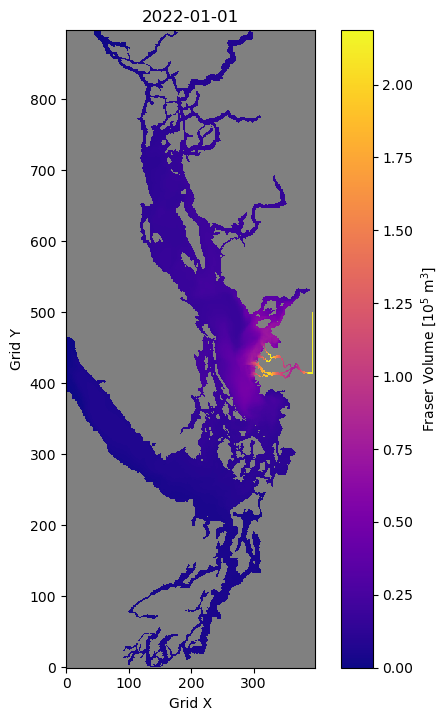

In [30]:
river = 'fraser_river'
fname = '{}_daily_animation_surf_2022'.format(river)
writervideo = animation.FFMpegWriter(fps=10)
cmap = mpl.colormaps['plasma']
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 1, figsize=(6, 7))
fig.tight_layout(pad=1.2)

depth = 0
river_surf = vol_2022['fraser_river'].isel(depth=depth)/(100000)
X = vol_2022.gridX
Y = vol_2022.gridY
Z = np.ma.masked_array(river_surf.isel(time=0), mask=tmask[depth])
colours = ax.pcolormesh(X, Y, Z, cmap=cmap)
cb = fig.colorbar(colours, ax=ax, label=r'Fraser Volume [$10^5$ m$^3$]')
viz_tools.set_aspect(ax);
# ax.set_xlim(180,350)
# ax.set_ylim(180,330)

def newframe(frame_num):
    freshwater = np.ma.masked_array(river_surf.isel(time=frame_num), mask=tmask[depth])
    Z = freshwater
    colours.set_array(Z.ravel())
    dtime = pd.to_datetime(vol_2022['time'].values[frame_num])
    ax.set_title('{}'.format(str(dtime.date())))
    viz_tools.set_aspect(ax);
    # ax.set_xlim(180,350)
    # ax.set_ylim(180,330)

ax.set_xlabel('Grid X')
ax.set_ylabel('Grid Y')

ani = FuncAnimation(fig, newframe, frames=len(vol_2022['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/stories/puget_sound/animations/{}.mp4'.format(fname), writer=writervideo)

## Smaller Map Area

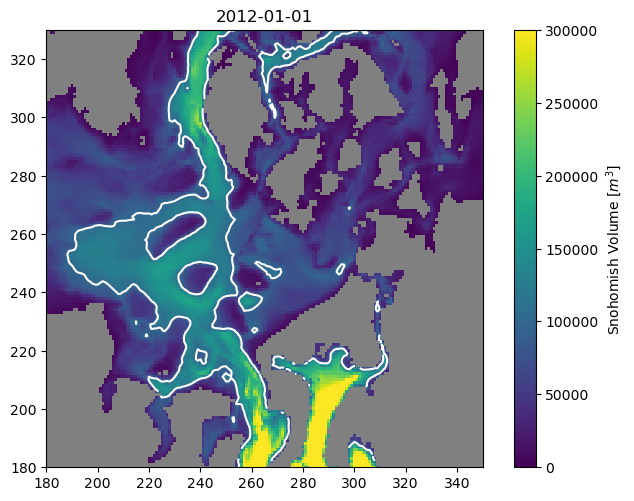

In [13]:
river = 'snohomish_river'
fname = '{}_daily_animation_sum_crop_2022'.format(river)
writervideo = animation.FFMpegWriter(fps=10)
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
fig.tight_layout(pad=1.2)

cont_vals = [0.10e6]
depth = 0
river_sum = sum_2022['snohomish_river']
X = fw.gridX
Y = fw.gridY
Z = np.ma.masked_array(river_sum.isel(time=0), mask=tmask[depth])
colours = ax.pcolormesh(X, Y, Z, cmap=cmap, vmax=0.3e6)
cb = fig.colorbar(colours, ax=ax, label=r'Snohomish Volume [$m^3$]')
viz_tools.set_aspect(ax);
ax.set_xlim(180,350)
ax.set_ylim(180,330)
cont = ax.contour(X, Y, Z, cont_vals, colors='white')

def newframe(frame_num):
    ax.clear()
    freshwater = np.ma.masked_array(river_sum.isel(time=frame_num), mask=tmask[depth])
    Z = freshwater
    colours = ax.pcolormesh(X, Y, Z, cmap=cmap, vmax=0.3e6)
    colours.set_array(Z.ravel())
    dtime = pd.to_datetime(fw['time'].values[frame_num])
    ax.set_title('{}'.format(str(dtime.date())))
    viz_tools.set_aspect(ax);
    ax.set_xlim(180,350)
    ax.set_ylim(180,330)
    cont = ax.contour(X, Y, Z, cont_vals, colors='white')

ani = FuncAnimation(fig, newframe, frames=len(sum_2022['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/stories/puget_sound/animations/{}.mp4'.format(fname), writer=writervideo)

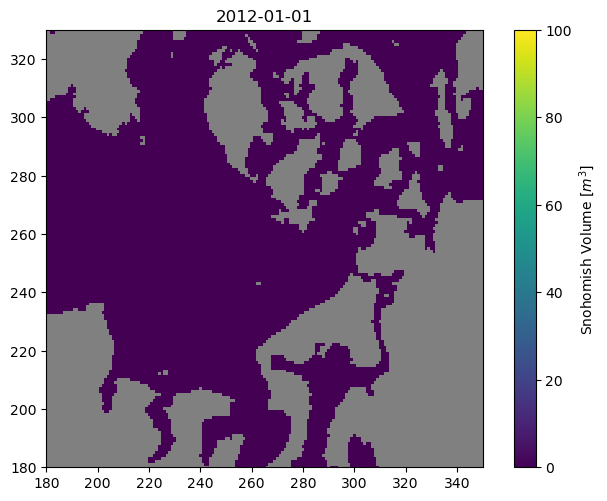

In [13]:
river = 'snohomish_river'
fname = '{}_daily_animation_depth0_crop_2022'.format(river)
writervideo = animation.FFMpegWriter(fps=10)
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
fig.tight_layout(pad=1.2)

cont_vals = [0.10e6]
depth = 0
river = fw[river].isel(depth=depth)
X = fw.gridX
Y = fw.gridY
Z = np.ma.masked_array(river.isel(time=0), mask=tmask[depth])
colours = ax.pcolormesh(X, Y, Z, cmap=cmap, vmax=100)
cb = fig.colorbar(colours, ax=ax, label=r'Snohomish Volume [$m^3$]')
viz_tools.set_aspect(ax);
ax.set_xlim(180,350)
ax.set_ylim(180,330)
# cont = ax.contour(X, Y, Z, cont_vals, colors='white')

def newframe(frame_num):
    ax.clear()
    freshwater = np.ma.masked_array(river.isel(time=frame_num), mask=tmask[depth])
    Z = freshwater
    colours = ax.pcolormesh(X, Y, Z, cmap=cmap, vmax=100)
    colours.set_array(Z.ravel())
    dtime = pd.to_datetime(fw['time'].values[frame_num])
    ax.set_title('{}'.format(str(dtime.date())))
    viz_tools.set_aspect(ax);
    ax.set_xlim(180,350)
    ax.set_ylim(180,330)
    # cont = ax.contour(X, Y, Z, cont_vals, colors='white')

ani = FuncAnimation(fig, newframe, frames=len(sum_2022['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/stories/puget_sound/animations/{}.mp4'.format(fname), writer=writervideo)

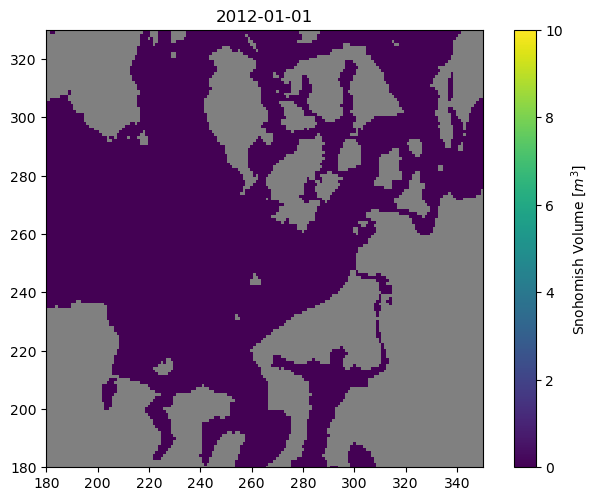

In [15]:
river = 'snohomish_river'
fname = '{}_daily_animation_depth10_crop_2022'.format(river)
writervideo = animation.FFMpegWriter(fps=10)
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
fig.tight_layout(pad=1.2)

cont_vals = [0.10e6]
depth = 10
river = fw[river].isel(depth=depth)
X = fw.gridX
Y = fw.gridY
Z = np.ma.masked_array(river.isel(time=0), mask=tmask[depth])
colours = ax.pcolormesh(X, Y, Z, cmap=cmap, vmax=10)
cb = fig.colorbar(colours, ax=ax, label=r'Snohomish Volume [$m^3$]')
viz_tools.set_aspect(ax);
ax.set_xlim(180,350)
ax.set_ylim(180,330)
# cont = ax.contour(X, Y, Z, cont_vals, colors='white')

def newframe(frame_num):
    ax.clear()
    freshwater = np.ma.masked_array(river.isel(time=frame_num), mask=tmask[depth])
    Z = freshwater
    colours = ax.pcolormesh(X, Y, Z, cmap=cmap, vmax=10)
    colours.set_array(Z.ravel())
    dtime = pd.to_datetime(fw['time'].values[frame_num])
    ax.set_title('{}'.format(str(dtime.date())))
    viz_tools.set_aspect(ax);
    ax.set_xlim(180,350)
    ax.set_ylim(180,330)
    # cont = ax.contour(X, Y, Z, cont_vals, colors='white')

ani = FuncAnimation(fig, newframe, frames=len(sum_2022['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/stories/puget_sound/animations/{}.mp4'.format(fname), writer=writervideo)

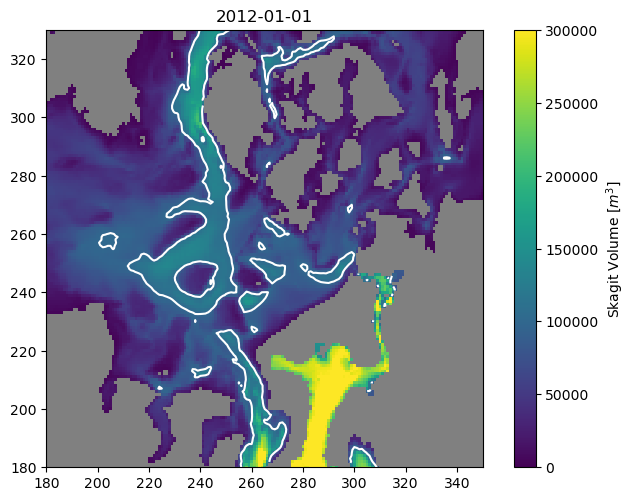

In [14]:
river = 'skagit_river'
fname = '{}_daily_animation_sum_crop_2022'.format(river)
writervideo = animation.FFMpegWriter(fps=10)
cmap = mpl.colormaps['viridis']
cmap.set_bad('gray')

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
fig.tight_layout(pad=1.2)

cont_vals = [0.10e6]
depth = 0
river_sum = sum_2022['skagit_river']
X = fw.gridX
Y = fw.gridY
Z = np.ma.masked_array(river_sum.isel(time=0), mask=tmask[depth])
colours = ax.pcolormesh(X, Y, Z, cmap=cmap, vmax=0.3e6)
cb = fig.colorbar(colours, ax=ax, label=r'Skagit Volume [$m^3$]')
viz_tools.set_aspect(ax);
ax.set_xlim(180,350)
ax.set_ylim(180,330)
cont = ax.contour(X, Y, Z, cont_vals, colors='white')

def newframe(frame_num):
    ax.clear()
    freshwater = np.ma.masked_array(river_sum.isel(time=frame_num), mask=tmask[depth])
    Z = freshwater
    colours = ax.pcolormesh(X, Y, Z, cmap=cmap, vmax=0.3e6)
    colours.set_array(Z.ravel())
    dtime = pd.to_datetime(fw['time'].values[frame_num])
    ax.set_title('{}'.format(str(dtime.date())))
    viz_tools.set_aspect(ax);
    ax.set_xlim(180,350)
    ax.set_ylim(180,330)
    cont = ax.contour(X, Y, Z, cont_vals, colors='white')

ani = FuncAnimation(fig, newframe, frames=len(sum_2022['time']), repeat=False)
ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/stories/puget_sound/animations/{}.mp4'.format(fname), writer=writervideo)